<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-형태소-분석" data-toc-modified-id="1.-형태소-분석-1">1. 형태소 분석</a></span></li><li><span><a href="#2.-감성분석-모델-만들기" data-toc-modified-id="2.-감성분석-모델-만들기-2">2. 감성분석 모델 만들기</a></span></li></ul></div>

In [1]:
import scipy as sp
import pandas as pd
import numpy as np

from konlpy.tag import Kkma        ; kkma = Kkma()
from konlpy.tag import Hannanum    ; hannanum = Hannanum()
from konlpy.tag import Okt         ; t = Okt()     # 구 트위터
from konlpy.tag import *
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 팍스넷 + 네이버 뉴스데이터 연결하기

news_df = pd.read_csv('팍스넷&네이버_뉴스타이틀.csv')
print(news_df.shape)
news_df

(8470, 3)


,Unnamed: 0,뉴스제목,주가변동
0,0,글로벌 큰손들 '검은 연기 내뿜는 기업' 투자 외면,0
1,1,"[특징주]한국바이오젠, 日 수출규제 속 국내 유일 실리콘 합성기술 보유 부각…공모가 상회",0
2,2,한국증시도 실망… 변동성 커졌다 [美 기준금리 0.25%P 인하],0
3,3,"[특징주] 첨생법, 국회 법사위 통과…관련株 강세",0
4,4,[유튜브 이대로 좋은가]③수익 관리감독 사각지대?,0
5,5,"코스피, 외인·기관 동반 순매도에 2010선 위협… 코스닥 620선",0
6,6,[줌인]감정 싸움된 에스엠 주주서한…본질 두고 엇갈린 해석,0
7,7,오전장 기술적 분석 특징주 A(코스닥),0
8,8,[유튜브 이대로 좋은가]②어린이 직접 광고 금지...보람튜브는 왜?,0
9,9,[뉴욕증시] 연준 추가 인하 힌트 기다리던 월가 '실망',0


In [3]:
title_list = news_df.뉴스제목.values.tolist()

In [4]:
print(len(title_list))
title_list

8470


["글로벌 큰손들 '검은 연기 내뿜는 기업' 투자 외면",
 '[특징주]한국바이오젠, 日 수출규제 속 국내 유일 실리콘 합성기술 보유 부각…공모가 상회',
 '한국증시도 실망… 변동성 커졌다 [美 기준금리 0.25%P 인하]',
 '[특징주] 첨생법, 국회 법사위 통과…관련株 강세',
 '[유튜브 이대로 좋은가]③수익 관리감독 사각지대?',
 '코스피, 외인·기관 동반 순매도에 2010선 위협… 코스닥 620선',
 '[줌인]감정 싸움된 에스엠 주주서한…본질 두고 엇갈린 해석',
 '오전장 기술적 분석 특징주 A(코스닥)',
 '[유튜브 이대로 좋은가]②어린이 직접 광고 금지...보람튜브는 왜?',
 "[뉴욕증시] 연준 추가 인하 힌트 기다리던 월가 '실망'",
 '증시요약(10) - 기술적 분석 특징주 B(코스닥)',
 '[코스피 마감]파월에 실망한 증시…2020선 내줘',
 '"전망 밝은 \'자동차·증권·반도체\'로 8월 코스피 반등 대비"',
 "[Bio톡스] 국회 통과 앞둔 '첨생법'…“재생의료 관련주 수혜 기대”",
 '증시요약(9) - 기술적 분석 특징주 A(코스닥)',
 "금리인하·호실적 전망에도 '증시 부진', 힘 못쓰는 증권주",
 '오후장 기술적 분석 특징주 A(코스닥)',
 '[굿모닝 증시]“한국 6월 산업활동, 경기 바닥 확인 시점 지연”',
 '오후장 특징주★(코스닥)',
 '전일대비 거래량 급증 종목(코스닥)',
 '실적 확인한 제약株…신약개발 모멘텀 딛고 반등',
 '오전장 기술적 분석 특징주 B(코스닥)',
 '코스피, 이틀 연속 내리며 2010선 후퇴… 코스닥 620선',
 "[특징주]보령메디앙스, '애국테마주' 전망에 급등",
 '[특징주] 제일약품 "표적항암제, 기존 美 FDA 승인 신약보다 효과 탁월"…신약 가치 \'↑\'',
 '바이오 주주분들 희소식입니다',
 '코스닥 상승률 상위 50종목',
 '[코스닥 마감]내우외환에 1% 넘게 하락…630선 하회',
 '오후장 기술적 분석 특징주 B(코스닥)',
 '설 땅 좁아지는 

In [5]:
title_text = ''

for each_line in title_list:
    title_text = title_text + each_line + '\n'
    
title_text

'글로벌 큰손들 \'검은 연기 내뿜는 기업\' 투자 외면\n[특징주]한국바이오젠, 日 수출규제 속 국내 유일 실리콘 합성기술 보유 부각…공모가 상회\n한국증시도 실망… 변동성 커졌다 [美 기준금리 0.25%P 인하]\n[특징주] 첨생법, 국회 법사위 통과…관련株 강세\n[유튜브 이대로 좋은가]③수익 관리감독 사각지대?\n코스피, 외인·기관 동반 순매도에 2010선 위협… 코스닥 620선\n[줌인]감정 싸움된 에스엠 주주서한…본질 두고 엇갈린 해석\n오전장 기술적 분석 특징주 A(코스닥)\n[유튜브 이대로 좋은가]②어린이 직접 광고 금지...보람튜브는 왜?\n[뉴욕증시] 연준 추가 인하 힌트 기다리던 월가 \'실망\'\n증시요약(10) - 기술적 분석 특징주 B(코스닥)\n[코스피 마감]파월에 실망한 증시…2020선 내줘\n"전망 밝은 \'자동차·증권·반도체\'로 8월 코스피 반등 대비"\n[Bio톡스] 국회 통과 앞둔 \'첨생법\'…“재생의료 관련주 수혜 기대”\n증시요약(9) - 기술적 분석 특징주 A(코스닥)\n금리인하·호실적 전망에도 \'증시 부진\', 힘 못쓰는 증권주\n오후장 기술적 분석 특징주 A(코스닥)\n[굿모닝 증시]“한국 6월 산업활동, 경기 바닥 확인 시점 지연”\n오후장 특징주★(코스닥)\n전일대비 거래량 급증 종목(코스닥)\n실적 확인한 제약株…신약개발 모멘텀 딛고 반등\n오전장 기술적 분석 특징주 B(코스닥)\n코스피, 이틀 연속 내리며 2010선 후퇴… 코스닥 620선\n[특징주]보령메디앙스, \'애국테마주\' 전망에 급등\n[특징주] 제일약품 "표적항암제, 기존 美 FDA 승인 신약보다 효과 탁월"…신약 가치 \'↑\'\n바이오 주주분들 희소식입니다\n코스닥 상승률 상위 50종목\n[코스닥 마감]내우외환에 1% 넘게 하락…630선 하회\n오후장 기술적 분석 특징주 B(코스닥)\n설 땅 좁아지는 탄소배출 기업…"블랙록, 한전·두산 탓에 손실"\n[특징주]서울반도체, 2분기 실적부진에 약세…52주 신저가\n연준의 ‘매파 기조 섞인 금리

# 1. 형태소 분석

In [6]:
tokens_ko = t.morphs(title_text)

In [7]:
tokens_ko

['글로벌',
 '큰손',
 '들',
 "'",
 '검은',
 '연기',
 '내뿜는',
 '기업',
 "'",
 '투자',
 '외면',
 '\n',
 '[',
 '특징',
 '주',
 ']',
 '한국',
 '바이오',
 '젠',
 ',',
 '日',
 '수출',
 '규제',
 '속',
 '국내',
 '유일',
 '실리콘',
 '합성',
 '기술',
 '보유',
 '부각',
 '…',
 '공모',
 '가',
 '상회',
 '\n',
 '한국',
 '증시',
 '도',
 '실망',
 '…',
 '변동성',
 '커졌다',
 '[',
 '美',
 '기준금리',
 '0.25%',
 'P',
 '인하',
 ']',
 '\n',
 '[',
 '특징',
 '주',
 ']',
 '첨',
 '생법',
 ',',
 '국회',
 '법',
 '사위',
 '통과',
 '…',
 '관련',
 '株',
 '강세',
 '\n',
 '[',
 '유튜브',
 '이대로',
 '좋은가',
 ']',
 '③',
 '수익',
 '관리',
 '감독',
 '사각',
 '지대',
 '?',
 '\n',
 '코스피',
 ',',
 '외인',
 '·',
 '기관',
 '동반',
 '순',
 '매도',
 '에',
 '2010',
 '선',
 '위협',
 '…',
 '코스닥',
 '620',
 '선',
 '\n',
 '[',
 '줌',
 '인',
 ']',
 '감정',
 '싸움',
 '된',
 '에스엠',
 '주주',
 '서한',
 '…',
 '본질',
 '두고',
 '엇갈린',
 '해석',
 '\n',
 '오전',
 '장',
 '기술',
 '적',
 '분석',
 '특징',
 '주',
 'A',
 '(',
 '코스닥',
 ')',
 '\n',
 '[',
 '유튜브',
 '이대로',
 '좋은가',
 ']',
 '②',
 '어린이',
 '직접',
 '광고',
 '금지',
 '...',
 '보람',
 '튜브',
 '는',
 '왜',
 '?',
 '\n',
 '[',
 '뉴욕증시',
 ']',
 '연',
 '준',
 

In [8]:
import nltk
ko = nltk.Text(tokens_ko)
ko

<Text: 큰손 들 ' 검은 연기 내뿜는 기업 ' 투자 외면 
 [ 특징 주>

In [9]:
print(len(ko.tokens))          # 토큰 전체 개수
print(len(set(ko.tokens)))     # 토큰 unique 개수

118481
12000


In [10]:
# 빈도수가 높은 단어 출력

ko.vocab().most_common(200)

[('\n', 8470),
 ("'", 3015),
 ('…', 2660),
 (',', 2547),
 ('(', 2146),
 (')', 2135),
 ('[', 2117),
 (']', 2010),
 ('"', 1740),
 ('주', 1628),
 ('코스닥', 1489),
 ('에', 1447),
 ('특징', 1425),
 ('종목', 1339),
 ('·', 922),
 ('장', 844),
 ('코스피', 792),
 ('증시', 747),
 ('-', 685),
 ('적', 621),
 ('도', 587),
 ('기술', 569),
 ('상위', 544),
 ('분석', 528),
 ('마감', 522),
 ('‘', 502),
 ('요약', 452),
 ('`', 451),
 ('가', 438),
 ('의', 436),
 ('’', 436),
 ('이', 406),
 ('기준', 380),
 ('오전', 368),
 ('★', 360),
 ('매수', 356),
 ('은', 337),
 ('“', 321),
 ('株', 311),
 ('하락', 307),
 ('대', 299),
 ('”', 297),
 ('삼성', 293),
 ('순', 290),
 ('발동', 286),
 ('한', 285),
 ('로', 279),
 ('B', 278),
 ('?', 274),
 ('A', 266),
 ('선', 265),
 ('3', 260),
 ('오후', 253),
 ('공시', 251),
 ('는', 247),
 ('日', 242),
 ('거래', 241),
 ('중', 232),
 ('5', 225),
 ('후', 223),
 ('주요', 221),
 ('바이오', 218),
 ('상승', 215),
 ('계', 214),
 ('한국', 213),
 ('투자', 212),
 ('강세', 207),
 ('"…', 205),
 ('!', 205),
 ('단독', 199),
 ('상', 198),
 ('들', 195),
 ('1', 190),
 ('2',

In [11]:
# 불용어(stopwords) 제거하기

stop_words = ['\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
              '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
              '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
              '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
              '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
             '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
             '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
             '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
             '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
             '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
             '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
             "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최']

tokens_ko = [each_word for each_word in tokens_ko
           if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)

[('상위', 544),
 ('기준', 380),
 ('매수', 356),
 ('株', 311),
 ('하락', 307),
 ('삼성', 293),
 ('순', 290),
 ('발동', 286),
 ('공시', 251),
 ('日', 242),
 ('거래', 241),
 ('후', 223),
 ('주요', 221),
 ('바이오', 218),
 ('상승', 215),
 ('한국', 213),
 ('투자', 212),
 ('강세', 207),
 ('외국', 186),
 ('속보', 172),
 ('일본', 170),
 ('완화', 169),
 ('美', 166),
 ('외국인', 165),
 ('↑', 159),
 ('아파트', 153),
 ('정부', 149),
 ('변동성', 146),
 ('수량', 143),
 ('장치', 140),
 ('전자', 140),
 ('무역', 130),
 ('증권', 128),
 ('급증', 128),
 ('+', 128),
 ('中', 126),
 ('대출', 126),
 ('대비', 125),
 ('못', 125),
 ('뉴스', 123),
 ('기관', 122),
 ('급등', 122),
 ('섹터', 121),
 ('반도체', 117),
 ('韓', 117),
 ('종합', 117),
 ('경제', 115),
 ('신고', 114),
 ('전일', 113),
 ('집값', 110),
 ('실적', 109),
 ('수출', 108),
 ('뉴욕증시', 108),
 ('규제', 105),
 ('기대', 105),
 ('기업', 104),
 ('서울', 102),
 ('집', 102),
 ('화', 101),
 ('시간', 99),
 ('주식', 99),
 ('내년', 99),
 ('LG', 99),
 ('협상', 96),
 ('이상', 95),
 ('첫', 92),
 ('주택', 91),
 ('회장', 90),
 ('우한', 89),
 ('매도', 88),
 ('돈', 88),
 ('강남', 88),
 ('상승세', 87)

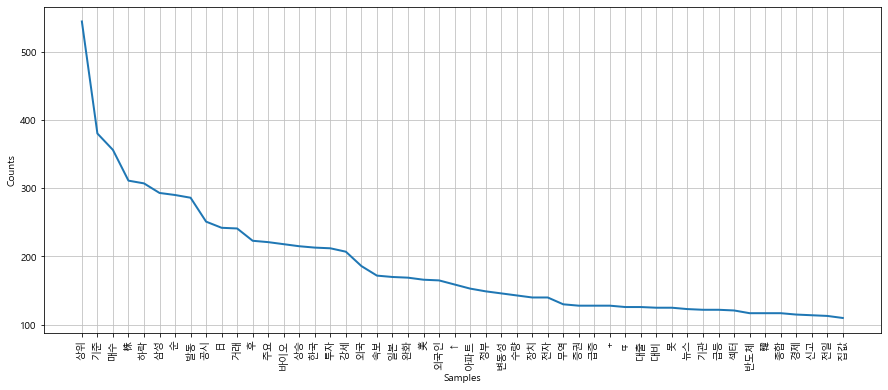

In [12]:
# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

import graphviz
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

In [13]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [14]:
data = ko.vocab().most_common(300)
data

[('상위', 544),
 ('기준', 380),
 ('매수', 356),
 ('株', 311),
 ('하락', 307),
 ('삼성', 293),
 ('순', 290),
 ('발동', 286),
 ('공시', 251),
 ('日', 242),
 ('거래', 241),
 ('후', 223),
 ('주요', 221),
 ('바이오', 218),
 ('상승', 215),
 ('한국', 213),
 ('투자', 212),
 ('강세', 207),
 ('외국', 186),
 ('속보', 172),
 ('일본', 170),
 ('완화', 169),
 ('美', 166),
 ('외국인', 165),
 ('↑', 159),
 ('아파트', 153),
 ('정부', 149),
 ('변동성', 146),
 ('수량', 143),
 ('장치', 140),
 ('전자', 140),
 ('무역', 130),
 ('증권', 128),
 ('급증', 128),
 ('+', 128),
 ('中', 126),
 ('대출', 126),
 ('대비', 125),
 ('못', 125),
 ('뉴스', 123),
 ('기관', 122),
 ('급등', 122),
 ('섹터', 121),
 ('반도체', 117),
 ('韓', 117),
 ('종합', 117),
 ('경제', 115),
 ('신고', 114),
 ('전일', 113),
 ('집값', 110),
 ('실적', 109),
 ('수출', 108),
 ('뉴욕증시', 108),
 ('규제', 105),
 ('기대', 105),
 ('기업', 104),
 ('서울', 102),
 ('집', 102),
 ('화', 101),
 ('시간', 99),
 ('주식', 99),
 ('내년', 99),
 ('LG', 99),
 ('협상', 96),
 ('이상', 95),
 ('첫', 92),
 ('주택', 91),
 ('회장', 90),
 ('우한', 89),
 ('매도', 88),
 ('돈', 88),
 ('강남', 88),
 ('상승세', 87)

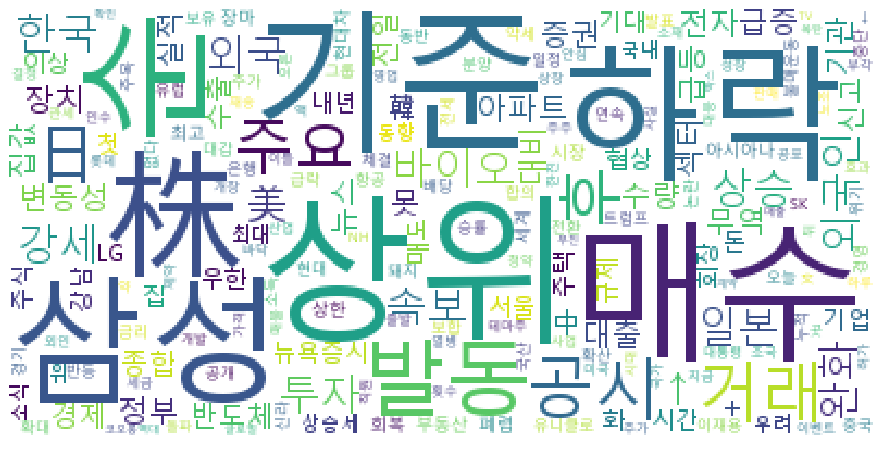

In [15]:
# 워드클라우드를 그려보자

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 돼지저금통 그림에 집어넣기

# 2. 감성분석 모델 만들기

In [16]:
news_df.head()

,Unnamed: 0,뉴스제목,주가변동
0,0,글로벌 큰손들 '검은 연기 내뿜는 기업' 투자 외면,0
1,1,"[특징주]한국바이오젠, 日 수출규제 속 국내 유일 실리콘 합성기술 보유 부각…공모가 상회",0
2,2,한국증시도 실망… 변동성 커졌다 [美 기준금리 0.25%P 인하],0
3,3,"[특징주] 첨생법, 국회 법사위 통과…관련株 강세",0
4,4,[유튜브 이대로 좋은가]③수익 관리감독 사각지대?,0


In [17]:
# 형태소 분석을 위한 함수

def tokenizer(text):
    okt = Okt()
    return okt.morphs(text)

In [23]:
def data_preprocessing():
    # 수집한 데이터 읽어오기
    # news_df = pd.read_excel()
    
    # 학습셋, 테스트셋 분리
    title_list = news_df['뉴스제목'].tolist()
    price_list = news_df['주가변동'].tolist()
    
    from sklearn.model_selection import train_test_split
    
    # 데이터의 80%는 학습셋, 20%는 테스트셋
    title_train, title_test, price_train, price_test = train_test_split(title_list, price_list, test_size=0.2, random_state=0)
    
    return title_train, title_test, price_train, price_test

In [24]:
def learning(x_train, y_train, x_test, y_test):
    # 전처리가 끝난 데이터를 단어 사전으로 만들고
    # 리뷰별로 나오는 단어를 파악해서 수치화 (벡터화)해서 학습
    # tfidf, 로지스틱 회귀 이용
    
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)
    # 로지스틱
    logistic = LogisticRegression(C=2, penalty='l2', random_state=0)     # C의 숫자가 너무 크면 과적합 (기본 1), penalty로 과적합 방지
    
    pipe = Pipeline([('vect',tfidf),('clf',logistic)])
    
    # 학습
    pipe.fit(x_train, y_train)
    
    # 학습 정확도 측정
    y_pred = pipe.predict(x_test)
    print(accuracy_score(y_test, y_pred))
    
    # 학습한 모델을 저장
    with open('pipe.dat', 'wb') as fp:     # 쓰기, 바탕화면에 저장됨
        pickle.dump(pipe, fp)
        
    print('저장완료')     # 학습된 모델 저장 완료

In [25]:
def using():
    # 객체를 복원, 저장된 모델 불러오기
    with open('pipe.dat','rb') as fp:     # 읽기
        pipe = pickle.load(fp)
        
    while True :
        text = input('뉴스 타이틀을 입력해주세요 : ')     # 인풋
        
        str = [text]
        
        # 예측 정확도
        r1 = np.max(pipe.predict_proba(str)*100)     # 확률값을 구해서 *100..?
        
        # 예측 결과
        r2 = pipe.predict(str)[0]     # 긍정('1'), 부정('0')
        
        if r2 == '1':
            print('코스피지수는 상승할 것으로 예상됩니다.')
        else: 
            print('코스피지수는 하락할 것으로 예상됩니다.')
            
        print('정확도 : %.3f' % r1)
        print('------------------------------------------------')

In [26]:
# 학습 함수

def model_learning():   # 감성분석 모델 생성
    title_train, title_test, price_train, price_test = data_preprocessing()
    learning(title_train, price_train, title_test, price_test)
    
# 사용 함수

def model_using():   # 감성분석 모델 사용
    using()

In [27]:
model_learning()

0.5997638724911453
저장완료


In [ ]:
model_using()

뉴스 타이틀을 입력해주세요 : 상승
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 53.785
------------------------------------------------
뉴스 타이틀을 입력해주세요 : 하락
코스피지수는 하락할 것으로 예상됩니다.
정확도 : 81.768
------------------------------------------------
